<a href="https://colab.research.google.com/github/raslocks/puntaje_diana/blob/main/Puntaje_Diana_model_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python
## -*- coding: utf-8 -*-
__author__ = ["Ing. Alberto Lepe de los Angeles"]
__credits__ = ["Ing. Alberto Lepe de los Angeles"]
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = ["Ing. Alberto Lepe de los Angeles"]
__email__ = "alberto.lepe@edu.uag.mx"
__status__ = "Development"

#Implementación de un algorimo CNN para la obtención automatica de puntaje en entrenamientos de tiro con arco

> Una red neuronal convolucional **(CNN)** es una variante de la MLP diseñado específicamente para reconocer formas bidimensionales con un alto grado de invariancia a la traslación, escalado, sesgo y otras formas de distorsión, donde generalmente son datos de imágenes.

> Se busca implementar un algoritmo que realiza la detección de coordenadas de la puntuación de flechas mediante el uso de redes neuronales CNN, de tal manera, la métrica de desmepeño a reducir es la del error **MSE** y **MAE** de la regresión. 


# Desarrollo

### Contenido:
* 1. [Importar conjunto de datos](#scrollTo=pfmpGGaWxwLP&line=1&uniqifier=1)
 * 2. [Escalamiento de datos](#scrollTo=iI8HWvrEyR-F&line=1&uniqifier=1)
* 3. [Generador de matriz de datos](#scrollTo=eQOwp25ZzVUL&line=1&uniqifier=1)
* 4. [Arquitectura CNN](#scrollTo=sWYFMFTMz5v7&line=1&uniqifier=1)
* 5. [Entrenamiento](#scrollTo=wDzJH2WI0UBD&line=1&uniqifier=1)
* 6. [Evalaución](#scrollTo=KU5u56xw0paE&line=2&uniqifier=1)
* 7. [Resultados](#scrollTo=SE6kfS1x1QZV&line=1&uniqifier=1)

## 1. Importar conjunto de datos
En esta sección se importan las librerias e importa el dataset de imagenes

In [ ]:
!cp '/content/drive/My Drive/dataset4.zip' ./
!cp '/content/drive/My Drive/dataset1.zip' ./
!unzip dataset4.zip
!unzip dataset1.zip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
origen_size = (448,448)
target_size = (224,224)

dir_train = '/content/dataset4/'
dir_test = '/content/dataset1/'

csv_train = '/content/dataset4.csv'
csv_test = '/content/dataset1.csv'

In [ ]:
data = pd.read_csv(csv_train)
drop_cols = ['f1','f2','f3','f4','f5','f6']
#drop_cols = ['f1','f2','f3','f4','f5']
#drop_cols = ['f1','f2','f3','f4']
#drop_cols = ['f1','f2','f3']
#drop_cols = ['f1','f2']
#drop_cols = ['f1']

data = data.drop(columns=drop_cols)
data.head()


,id,filename,f1p,f2p,f3p,f4p,f5p,f6p,f1x,f1y,f2x,f2y,f3x,f3y,f4x,f4y,f5x,f5y,f6x,f6y
0,0,0_Cam.001__2_8_1_4_4_8.jpg,2,8,1,4,4,8,338,189,244,201,106,313,126,278,159,119,168,233
1,1,1_Cam.001__1_2_2_5_5_1.jpg,1,2,2,5,5,1,193,385,172,71,344,217,153,297,178,304,96,267
2,2,2_Cam.003__6_1_2_4_3_2.jpg,6,1,2,4,3,2,316,179,422,151,133,395,330,138,152,77,59,115
3,3,3_Cam.000__7_7_1_4_2_7.jpg,7,7,1,4,2,7,198,186,212,284,77,121,193,341,72,231,301,204
4,4,4_Cam.002__2_1_4_5_4_5.jpg,2,1,4,5,4,5,52,265,383,314,194,350,212,334,99,207,102,243


In [ ]:
#n_flchs = data.iloc[0]['n_flchs']
n_flchs = 6
n_flchs = n_flchs * 2
print(n_flchs)
keypoint_cols = list(data.columns[-n_flchs:])
print(keypoint_cols)
rshape=(round(len(keypoint_cols)/2), 2)
print(rshape)
points_cols = list(data.columns[2:-n_flchs])
print(points_cols)

12
['f1x', 'f1y', 'f2x', 'f2y', 'f3x', 'f3y', 'f4x', 'f4y', 'f5x', 'f5y', 'f6x', 'f6y']
(6, 2)
['f1p', 'f2p', 'f3p', 'f4p', 'f5p', 'f6p']


In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

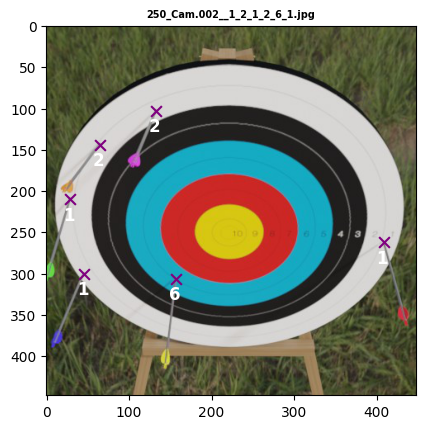

[5250, '250_Cam.002__1_2_1_2_6_1.jpg', 1, 2, 1, 2, 6, 1, 46, 300, 133, 103, 29, 210, 65, 144, 157, 306, 409, 262]


In [ ]:
sample = np.random.randint(len(data['filename']))
filename = data.iloc[sample]['filename']
img_true = image.load_img( dir_train + filename)
xy_true = data.iloc[sample][keypoint_cols].values.reshape(rshape)
score = data.iloc[sample][points_cols].values

#plt.scatter(xy_true[:, 0], xy_true[:, 1], marker="x", color="purple", s=60)
#dic_score =  dict(zip(list(range(len(points_cols))),score))
#dic_point =  dict(zip(list(range(len(xy_true[:, 0]))),xy_true))

for key in range(len(score)):
    label = str(score[key])
    plt.scatter(xy_true[key][0], xy_true[key][1], marker='x', color='purple', s=60)
    plt.text(xy_true[key][0]-9, xy_true[key][1]+25, label,fontweight='bold', fontsize=12, color="white")
    
plt.title(filename, fontweight='bold', fontsize=7)
plt.imshow(img_true)
plt.show()

print(list(data.iloc[sample][:]))


## 2. Escalamiento de datos
En esta sección se realizan ajuntes a los datos para que concuerde con el tamaño de entrada del modelo.

In [ ]:
def get_prct(tar_size, org_size):
  return [(tar_size[0] * 100) / org_size[0], (tar_size[1] * 100) / org_size[1]]

In [ ]:
#Escalamiento puntos Train
data_train = pd.read_csv(csv_train)
data_train = data.copy()
pcrt_xy = get_prct(target_size, origen_size)
puntos = np.asanyarray(data_train[keypoint_cols])
for i in puntos:
  xy_puntos = i.reshape(rshape)
  for j in xy_puntos:
    j[0] = j[0] * (pcrt_xy[0] / 100)
    j[1] = j[1] * (pcrt_xy[1] / 100)
new_data = pd.DataFrame(puntos,columns=keypoint_cols)
data_train.update(new_data)
data_train.head()

,id,filename,f1p,f2p,f3p,f4p,f5p,f6p,f1x,f1y,f2x,f2y,f3x,f3y,f4x,f4y,f5x,f5y,f6x,f6y
0,0,0_Cam.001__2_8_1_4_4_8.jpg,2,8,1,4,4,8,169,94,122,100,53,156,63,139,79,59,84,116
1,1,1_Cam.001__1_2_2_5_5_1.jpg,1,2,2,5,5,1,96,192,86,35,172,108,76,148,89,152,48,133
2,2,2_Cam.003__6_1_2_4_3_2.jpg,6,1,2,4,3,2,158,89,211,75,66,197,165,69,76,38,29,57
3,3,3_Cam.000__7_7_1_4_2_7.jpg,7,7,1,4,2,7,99,93,106,142,38,60,96,170,36,115,150,102
4,4,4_Cam.002__2_1_4_5_4_5.jpg,2,1,4,5,4,5,26,132,191,157,97,175,106,167,49,103,51,121


In [ ]:
#Escalar datos test
data_test = pd.read_csv(csv_test)
pcrt_xy = get_prct(target_size, origen_size)
puntos = np.asanyarray(data_test[keypoint_cols])
for i in puntos:
  xy_puntos = i.reshape(rshape)
  for j in xy_puntos:
    j[0] = j[0] * (pcrt_xy[0] / 100)
    j[1] = j[1] * (pcrt_xy[1] / 100)
new_data = pd.DataFrame(puntos,columns=keypoint_cols)
data_test.update(new_data)
data_test.head()

,id,filename,f1,f1p,f2,f2p,f3,f3p,f4,f4p,f5,f5p,f6,f6p,f1x,f1y,f2x,f2y,f3x,f3y,f4x,f4y,f5x,f5y,f6x,f6y
0,0,0_Cam.000__5_8_3_2_5_1.jpg,Flch0_azul,5,Flch6_morada,8,Flch1_verde,3,Flch2_naranja,2,Flch3_amarilla,5,Flch4_roja,1,117,173,147,110,87,30,103,13,124,174,65,22
1,1,1_Cam.003__1_2_3_7_4_1.jpg,Flch0_azul,1,Flch6_morada,2,Flch1_verde,3,Flch2_naranja,7,Flch3_amarilla,4,Flch4_roja,1,30,39,41,43,44,59,119,142,115,37,215,96
2,2,2_Cam.000__8_7_7_8_1_4.jpg,Flch0_azul,8,Flch6_morada,7,Flch1_verde,7,Flch2_naranja,8,Flch3_amarilla,1,Flch4_roja,4,139,99,105,78,96,122,142,129,184,89,69,99
3,3,3_Cam.002__4_1_5_4_1_2.jpg,Flch0_azul,4,Flch6_morada,1,Flch1_verde,5,Flch2_naranja,4,Flch3_amarilla,1,Flch4_roja,2,133,169,24,68,153,153,73,77,209,80,173,62
4,4,4_Cam.003__1_1_1_5_2_3.jpg,Flch0_azul,1,Flch6_morada,1,Flch1_verde,1,Flch2_naranja,5,Flch3_amarilla,2,Flch4_roja,3,19,158,24,47,100,7,144,52,126,206,32,104


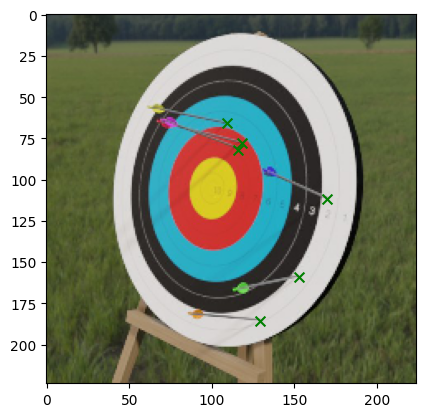

In [ ]:
#TRue values
sample = np.random.randint(len(data_test['filename']))
filename = data_test.iloc[sample]['filename']
img_true = image.load_img( dir_test + filename, target_size=target_size)
xy_true = data_test.iloc[sample][keypoint_cols].values.reshape(rshape)
plt.scatter(xy_true[:, 0], xy_true[:, 1], marker="x", color="green", s=50)

plt.imshow(img_true)
plt.show()

## 3. Generador de matriz de imágenes
ImageDataGenerator importa las imagenes en una matriz de imagenes

In [ ]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [ ]:
#Generador dataset para Train
#imgen_train = ImageDataGenerator(preprocessing_function=to_grayscale_then_rgb, rescale=1./255)
#imgen_train = ImageDataGenerator(preprocessing_function=to_grayscale_then_rgb)
imgen_train = ImageDataGenerator(rescale=1./255)
#imgen_train = ImageDataGenerator()
img_gen_train = imgen_train.flow_from_dataframe(
    dataframe = data_train,
    directory = dir_train,
    x_col='filename',
    y_col=keypoint_cols,
    class_mode='raw',
    #class_mode='multi_output',
    target_size=target_size,
    color_mode='rgb',
    #color_mode='grayscale',
    batch_size=64,
    shuffle=True
)

Found 7000 validated image filenames.


In [ ]:
#Generador dataset para Test
#imgen_test = ImageDataGenerator(preprocessing_function=to_grayscale_then_rgb, rescale=1./255)
#imgen_test = ImageDataGenerator(preprocessing_function=to_grayscale_then_rgb)
imgen_test = ImageDataGenerator(rescale=1./255)
#imgen_test = ImageDataGenerator()
img_gen_test = imgen_test.flow_from_dataframe(
    dataframe = data_test,
    directory = dir_test,
    x_col='filename',
    y_col=keypoint_cols,
    class_mode='raw',
    #class_mode='multi_output',
    target_size=target_size,
    color_mode='rgb',
    #color_mode='grayscale',
    batch_size=64,
    shuffle=False
)

Found 1000 validated image filenames.


In [ ]:
#Train
step_size_train = img_gen_train.n // img_gen_train.batch_size
img_shape_full = img_gen_train.image_shape
print(img_gen_train.n)
print(img_gen_train.batch_size)
print(img_gen_train.image_shape)

7000
64
(224, 224, 3)


In [ ]:
#Test
step_size_test = img_gen_test.n // img_gen_test.batch_size
img_shape_full = img_gen_test.image_shape
print(img_shape_full)
print(img_gen_test.n)
print(img_gen_test.batch_size)
print(img_gen_test.image_shape)

(224, 224, 3)
1000
64
(224, 224, 3)


## 4. Arquitectura CNN
En esta seccion se diseña el modelo de CNN y se compila

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, GlobalAveragePooling2D, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(img_shape_full)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(24, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(n_flchs,activation='linear'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 224, 224, 32)      864       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 224, 224, 32)      9216      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 32)     

In [ ]:
#model.compile(optimizer=Adam(), loss = ['mse'], metrics = ['mae'])
model.compile(optimizer=Adam(), loss = 'mse', metrics = ['mae', 'mse'])

## 5. Entrenamiento
Entrenamiento del modelo 100 épocas y 64 tamaño del lote

In [ ]:
history = model.fit(img_gen_train, steps_per_epoch=step_size_train, epochs=100, verbose=2)
#history = model.fit(img_gen_test, steps_per_epoch=step_size_test, epochs=50,verbose=2)

Epoch 1/100
109/109 - 87s - loss: 3220.9126 - mae: 45.6250 - mse: 3220.9126
Epoch 2/100
109/109 - 34s - loss: 2127.3459 - mae: 37.9262 - mse: 2127.3459
Epoch 3/100
109/109 - 34s - loss: 2069.9600 - mae: 37.3901 - mse: 2069.9600
Epoch 4/100
109/109 - 34s - loss: 2035.3203 - mae: 37.0932 - mse: 2035.3203
Epoch 5/100
109/109 - 34s - loss: 1904.9153 - mae: 35.5489 - mse: 1904.9153
Epoch 6/100
109/109 - 34s - loss: 1784.1927 - mae: 34.1334 - mse: 1784.1927
Epoch 7/100
109/109 - 34s - loss: 1739.7004 - mae: 33.7400 - mse: 1739.7004
Epoch 8/100
109/109 - 34s - loss: 1680.0830 - mae: 33.0036 - mse: 1680.0830
Epoch 9/100
109/109 - 35s - loss: 1500.7333 - mae: 30.5719 - mse: 1500.7333
Epoch 10/100
109/109 - 35s - loss: 1296.2764 - mae: 27.8145 - mse: 1296.2764
Epoch 11/100
109/109 - 35s - loss: 1165.4852 - mae: 26.0413 - mse: 1165.4852
Epoch 12/100
109/109 - 35s - loss: 1051.2627 - mae: 24.5192 - mse: 1051.2627
Epoch 13/100
109/109 - 34s - loss: 876.2074 - mae: 22.0217 - mse: 876.2074
Epoch 14/1

## 6. Evaluación


In [ ]:
hist = pd.DataFrame(history.history)

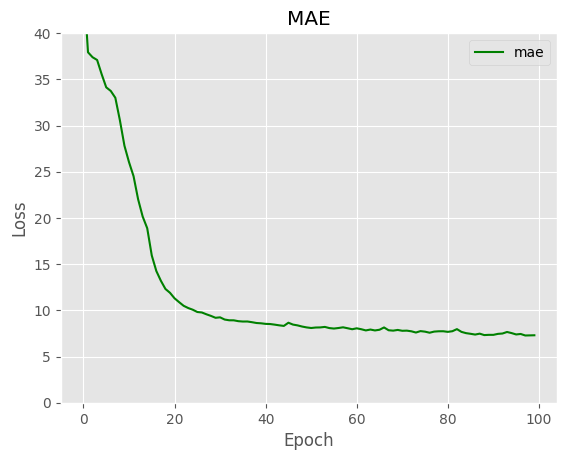

In [ ]:
def plot_history(history):
  plt.style.use('ggplot')
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.title('MAE')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['mae'], label = 'mae', color="green")
  plt.ylim([0,40])
  plt.legend()
  plt.show()

plot_history(history)

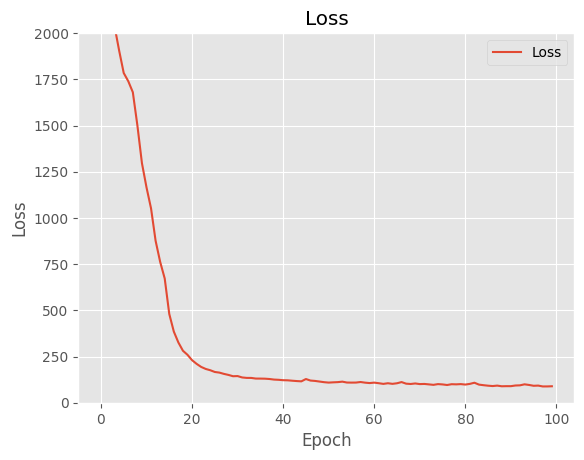

In [ ]:
def plot_history_loss(history):
  plt.style.use('ggplot')
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Loss')
  plt.ylim([0,2000])
  plt.legend()
  plt.show()

plot_history_loss(history)

In [ ]:
model.evaluate(img_gen_train,steps=step_size_train)

109/109 [==============================] - 29s 254ms/step - loss: 47.2184 - mae: 4.7037 - mse: 47.2184


[47.218414306640625, 4.703670978546143, 47.218414306640625]

In [ ]:
model.evaluate(img_gen_test, steps=step_size_test)

15/15 [==============================] - 4s 256ms/step - loss: 211.3545 - mae: 8.0351 - mse: 211.3545


[211.35450744628906, 8.035122871398926, 211.35450744628906]

## 5. Resultados

In [ ]:
#Y_pred_train = model.predict(img_gen_train, step_size_train)
Y_pred_test = model.predict(img_gen_test, step_size_test)

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
def mostrar_ejemplos_imgs(data_f, dir_img, n_ejemplos, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(10,7))

    for ind in range(n_ejemplos):
        sample = np.random.randint(len(data_f.filenames))
        img = image.load_img( dir_img + data_f.filenames[sample], target_size=target_size)
        filename = data_f.filenames[sample]
        
        input_arr = image.img_to_array(img)
        input_arr = np.array([input_arr])/255
        predict_diana = model.predict(input_arr)
        xy_predict = predict_diana.reshape(rshape)

        ax.ravel()[ind].imshow(img)
        ax.ravel()[ind].scatter(xy_predict[:, 0], xy_predict[:, 1], marker="x", color="green", s=50)
        ax.ravel()[ind].set_title(filename, fontweight='bold', fontsize=7)
        #ax.ravel()[ind].set_xlabel(filename)        
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

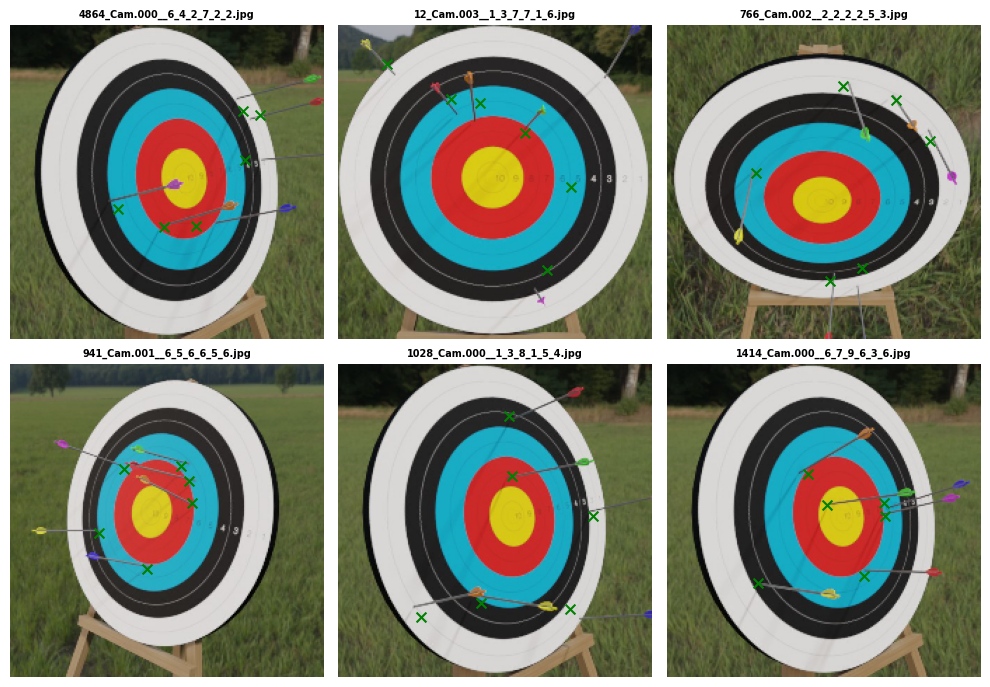

In [ ]:
#Mostrar predicciones del dataset de entrenamiento
mostrar_ejemplos_imgs(img_gen_train, dir_train,6,2,3)

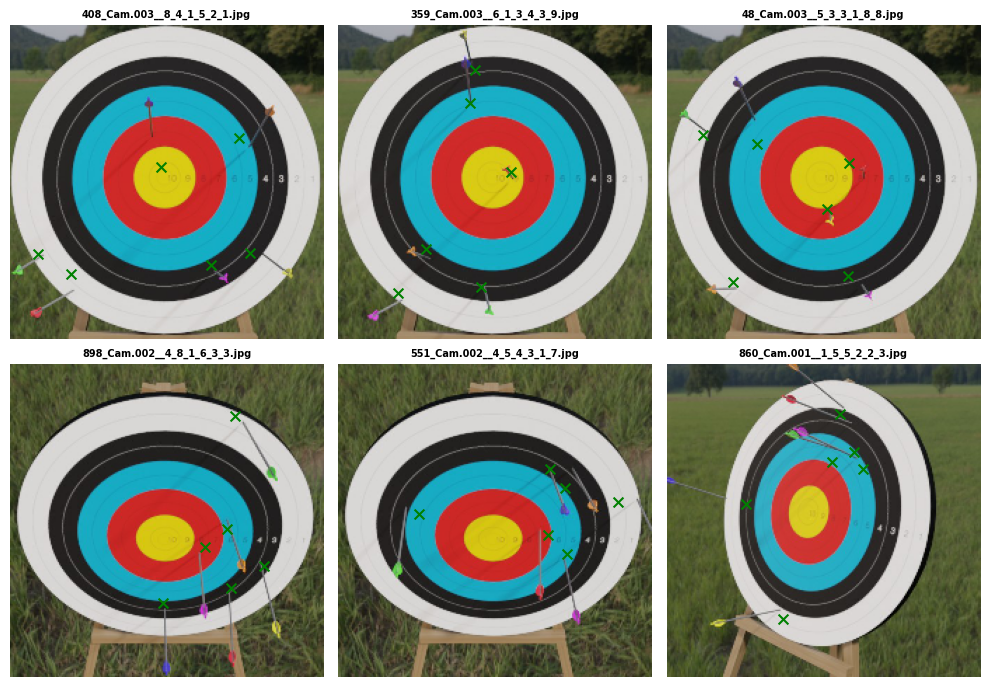

In [ ]:
#Mostrar predicciones del dataset de entrenamiento
mostrar_ejemplos_imgs(img_gen_test, dir_test,6,2,3)

In [ ]:
pred_keypoints_cols = []
for k in keypoint_cols:
    pred_keypoints_cols.append("pd_" + k)

pred_points_cols = []
for p in points_cols:
    pred_points_cols.append("pd_" + p)
    
val_pred_points_cols = []
for p in points_cols:
    val_pred_points_cols.append("vl_" + p)

In [ ]:
pred = pd.DataFrame(Y_pred_test, columns=pred_keypoints_cols)
pred_round = round(pred).astype(int)
df = pd.concat([data_test, pred_round], axis=1, join="inner")
df = df.drop(columns=drop_cols)
df.head()

,id,filename,f1p,f2p,f3p,f4p,f5p,f6p,f1x,f1y,f2x,f2y,f3x,f3y,f4x,f4y,f5x,f5y,f6x,f6y,pd_f1x,pd_f1y,pd_f2x,pd_f2y,pd_f3x,pd_f3y,pd_f4x,pd_f4y,pd_f5x,pd_f5y,pd_f6x,pd_f6y
0,0,0_Cam.000__5_8_3_2_5_1.jpg,5,8,3,2,5,1,117,173,147,110,87,30,103,13,124,174,65,22,107,147,131,100,84,37,96,15,134,188,72,52
1,1,1_Cam.003__1_2_3_7_4_1.jpg,1,2,3,7,4,1,30,39,41,43,44,59,119,142,115,37,215,96,98,70,64,50,40,58,122,142,105,36,165,102
2,2,2_Cam.000__8_7_7_8_1_4.jpg,8,7,7,8,1,4,139,99,105,78,96,122,142,129,184,89,69,99,140,104,113,73,106,125,146,132,148,98,85,104
3,3,3_Cam.002__4_1_5_4_1_2.jpg,4,1,5,4,1,2,133,169,24,68,153,153,73,77,209,80,173,62,137,163,35,76,163,148,80,83,194,88,178,70
4,4,4_Cam.003__1_1_1_5_2_3.jpg,1,1,1,5,2,3,19,158,24,47,100,7,144,52,126,206,32,104,31,139,29,54,98,17,114,61,119,198,23,108


In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

In [ ]:
X_Y = np.asanyarray(df[pred_keypoints_cols])
#X_Y = StandardScaler().fit_transform(X_Y)
scaler = StandardScaler().fit(X_Y)
xy_test = scaler.transform(X_Y)


Obtener puntaje por medio del modelo MLP

In [ ]:
!cp /content/drive/MyDrive/getscore_modelos/getscore_modelo_6flchs_dataset.h5 /content/

In [ ]:
model_getscore = load_model('/content/getscore_modelo_6flchs_dataset.h5')

In [ ]:
pred_score = model_getscore.predict(xy_test, step_size_train)
df_score = pd.DataFrame(pred_score, columns = pred_points_cols)
df_score[pred_points_cols] = np.where(df_score[pred_points_cols] > 9.5, 10.0, df_score[pred_points_cols])
df_score[pred_points_cols] = np.where(df_score[pred_points_cols] <= 0, 1, df_score[pred_points_cols])
df_score = round(df_score).astype(int)
df_score[pred_points_cols] = np.where(df_score[pred_points_cols] <= 0, 1, df_score[pred_points_cols])
df_res = pd.concat([df, df_score], axis=1, join="inner")
df_res['pred_sum'] = df_res[pred_points_cols].sum(axis=1)
df_res['sum'] = df_res[points_cols].sum(axis=1) 
#df_res.head()

In [ ]:
df_res[['filename'] + points_cols + ['sum'] + pred_points_cols + ['pred_sum']].head()

,filename,f1p,f2p,f3p,f4p,f5p,f6p,sum,pd_f1p,pd_f2p,pd_f3p,pd_f4p,pd_f5p,pd_f6p,pred_sum
0,0_Cam.000__5_8_3_2_5_1.jpg,5,8,3,2,5,1,24,6,9,3,2,3,4,27
1,1_Cam.003__1_2_3_7_4_1.jpg,1,2,3,7,4,1,18,6,3,2,7,3,4,25
2,2_Cam.000__8_7_7_8_1_4.jpg,8,7,7,8,1,4,35,6,6,9,6,5,7,39
3,3_Cam.002__4_1_5_4_1_2.jpg,4,1,5,4,1,2,17,4,2,4,6,1,2,19
4,4_Cam.003__1_1_1_5_2_3.jpg,1,1,1,5,2,3,13,1,1,2,7,3,2,16


In [ ]:
pred_points = np.asanyarray(df_res[pred_points_cols])
pd_pred_points = pd.DataFrame(pred_points, columns=points_cols)
pred_val = np.where( pd_pred_points == df_res[points_cols], 1, 0)

df_val = pd.DataFrame(pred_val, columns = [points_cols])
df_res['correctas'] = df_val[points_cols].sum(axis=1)
df_res.head()

,id,filename,f1p,f2p,f3p,f4p,f5p,f6p,f1x,f1y,f2x,f2y,f3x,f3y,f4x,f4y,f5x,f5y,f6x,f6y,pd_f1x,pd_f1y,pd_f2x,pd_f2y,pd_f3x,pd_f3y,pd_f4x,pd_f4y,pd_f5x,pd_f5y,pd_f6x,pd_f6y,pd_f1p,pd_f2p,pd_f3p,pd_f4p,pd_f5p,pd_f6p,pred_sum,sum,correctas
0,0,0_Cam.000__5_8_3_2_5_1.jpg,5,8,3,2,5,1,117,173,147,110,87,30,103,13,124,174,65,22,107,147,131,100,84,37,96,15,134,188,72,52,6,9,3,2,3,4,27,24,2
1,1,1_Cam.003__1_2_3_7_4_1.jpg,1,2,3,7,4,1,30,39,41,43,44,59,119,142,115,37,215,96,98,70,64,50,40,58,122,142,105,36,165,102,6,3,2,7,3,4,25,18,1
2,2,2_Cam.000__8_7_7_8_1_4.jpg,8,7,7,8,1,4,139,99,105,78,96,122,142,129,184,89,69,99,140,104,113,73,106,125,146,132,148,98,85,104,6,6,9,6,5,7,39,35,0
3,3,3_Cam.002__4_1_5_4_1_2.jpg,4,1,5,4,1,2,133,169,24,68,153,153,73,77,209,80,173,62,137,163,35,76,163,148,80,83,194,88,178,70,4,2,4,6,1,2,19,17,3
4,4,4_Cam.003__1_1_1_5_2_3.jpg,1,1,1,5,2,3,19,158,24,47,100,7,144,52,126,206,32,104,31,139,29,54,98,17,114,61,119,198,23,108,1,1,2,7,3,2,16,13,2


In [ ]:
def mostrar_predicciones(data_input, dir_img, n_ejemplos, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(10,7))
    for ind in range(n_ejemplos):
        sample = np.random.randint(len(data_input))
        filename = data_input.iloc[sample]['filename']
        img = image.load_img( dir_img + filename, target_size=target_size)
        
        #xy_true = data_input.iloc[sample][keypoint_cols].values.reshape(rshape)
        xy_predict = data_input.iloc[sample][pred_keypoints_cols].values.reshape(rshape)
        score = data_input.iloc[sample][pred_points_cols].values
        suma_pred = str(data_input.iloc[sample]['pred_sum'])
        suma_true = str(data_input.iloc[sample]['sum'])
        correct = str(data_input.iloc[sample]['correctas'])

        for key in range(len(score)):
          label = str(score[key])
          ax.ravel()[ind].scatter(xy_predict[key][0], xy_predict[key][1], marker='x', color='white', s=60)
          ax.ravel()[ind].text(xy_predict[key][0]-4, xy_predict[key][1]+12, label, fontweight='bold', fontsize=10, color="white")

        ax.ravel()[ind].text(5, 10, "score: " + suma_pred, fontweight='bold', fontsize=10, color="white")
        #ax.ravel()[ind].text(5, 20, "score: " + suma_true, fontweight='bold', fontsize=10, color="black")
        ax.ravel()[ind].text(180, 10, "ok: " + correct + "/" + str(rshape[0]) , fontweight='bold', fontsize=10, color="white")
        ax.ravel()[ind].set_title(filename, fontweight='bold', fontsize=7)
        ax.ravel()[ind].set_axis_off()
        ax.ravel()[ind].imshow(img)
    plt.tight_layout()
    plt.show()

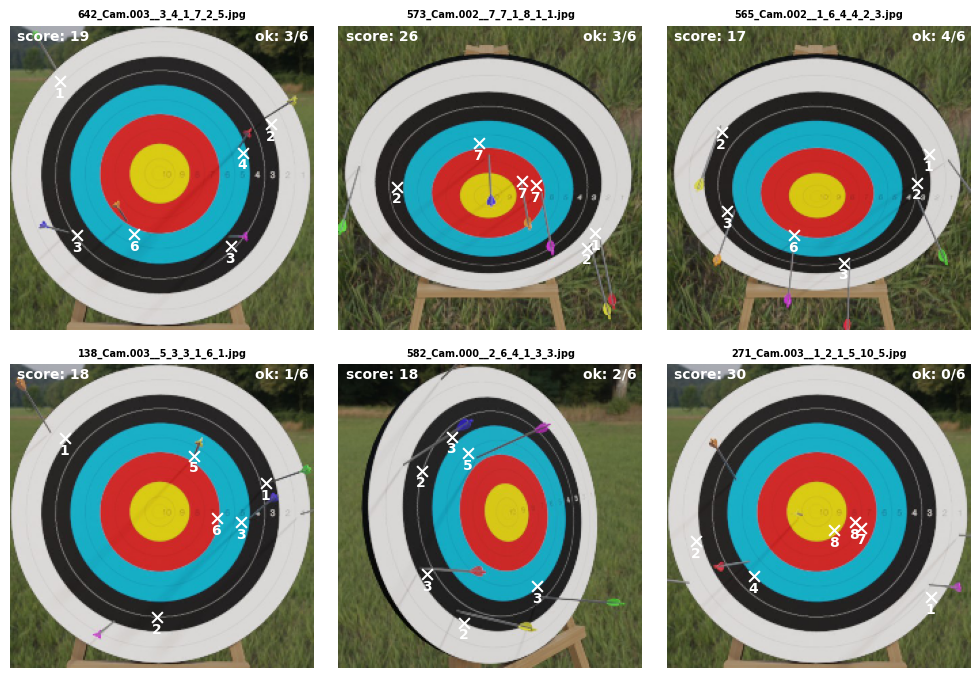

In [ ]:
mostrar_predicciones(df_res, dir_test,6,2,3)


In [ ]:
df_val['correctas'] = df_val[points_cols].sum(axis=1)
df_val[['correctas']].sum()

correctas    2070
dtype: int64

In [ ]:
df_res.head()

,id,filename,f1p,f2p,f3p,f4p,f5p,f6p,f1x,f1y,f2x,f2y,f3x,f3y,f4x,f4y,f5x,f5y,f6x,f6y,pd_f1x,pd_f1y,pd_f2x,pd_f2y,pd_f3x,pd_f3y,pd_f4x,pd_f4y,pd_f5x,pd_f5y,pd_f6x,pd_f6y,pd_f1p,pd_f2p,pd_f3p,pd_f4p,pd_f5p,pd_f6p,pred_sum,sum,correctas
0,0,0_Cam.000__5_8_3_2_5_1.jpg,5,8,3,2,5,1,117,173,147,110,87,30,103,13,124,174,65,22,107,147,131,100,84,37,96,15,134,188,72,52,6,9,3,2,3,4,27,24,2
1,1,1_Cam.003__1_2_3_7_4_1.jpg,1,2,3,7,4,1,30,39,41,43,44,59,119,142,115,37,215,96,98,70,64,50,40,58,122,142,105,36,165,102,6,3,2,7,3,4,25,18,1
2,2,2_Cam.000__8_7_7_8_1_4.jpg,8,7,7,8,1,4,139,99,105,78,96,122,142,129,184,89,69,99,140,104,113,73,106,125,146,132,148,98,85,104,6,6,9,6,5,7,39,35,0
3,3,3_Cam.002__4_1_5_4_1_2.jpg,4,1,5,4,1,2,133,169,24,68,153,153,73,77,209,80,173,62,137,163,35,76,163,148,80,83,194,88,178,70,4,2,4,6,1,2,19,17,3
4,4,4_Cam.003__1_1_1_5_2_3.jpg,1,1,1,5,2,3,19,158,24,47,100,7,144,52,126,206,32,104,31,139,29,54,98,17,114,61,119,198,23,108,1,1,2,7,3,2,16,13,2


In [ ]:

matx = pd.DataFrame([],columns=['score','pred_score','pred'])
for i in range(len(pred_points_cols)):
  a = points_cols[i]
  b = pred_points_cols[i]
  con = np.asanyarray(pd.concat([ df_res[[a]], df_res[[b]] , df_val[[a]] ], axis=1, join="inner"))
  val = pd.DataFrame(con, columns=['score','pred_score','pred'])
  matx = pd.concat([matx, val], axis=0, join="inner")

matx.head()

,score,pred_score,pred
0,5,6,0
1,1,6,0
2,8,6,0
3,4,4,1
4,1,1,1


In [ ]:
print("Aciertos: " + str(matx[matx["pred"]==1]['pred'].count()) )
print("Falsos: " + str(matx[matx["pred"]==0]['pred'].count()) )
print("Total: " + str(matx.shape[0]))

Aciertos: 2070
Falsos: 3930
Total: 6000


In [ ]:
import seaborn as sns
from sklearn import metrics

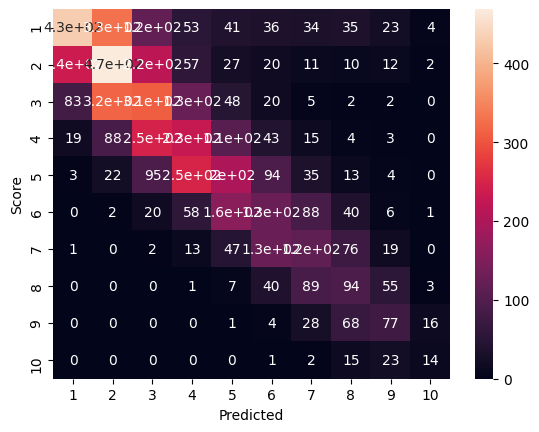

In [ ]:
confusion_matrix = pd.crosstab(matx['score'], matx['pred_score'], rownames=['Score'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
#round(matx).astype(int)
valor_true = list(np.array( matx['score'] ))
valor_pred = list(np.array( matx['pred_score'] ))
valor_labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#round(df_score).astype(int)
#print(valor_pred.shape)
print('Classification report: \n', metrics.classification_report(valor_true, valor_pred) )

Classification report: 
               precision    recall  f1-score   support

           1       0.56      0.39      0.46      1105
           2       0.38      0.44      0.41      1063
           3       0.31      0.34      0.32       913
           4       0.29      0.30      0.30       758
           5       0.31      0.28      0.29       716
           6       0.25      0.25      0.25       505
           7       0.28      0.29      0.28       402
           8       0.26      0.33      0.29       289
           9       0.34      0.40      0.37       194
          10       0.35      0.25      0.29        55

    accuracy                           0.34      6000
   macro avg       0.33      0.33      0.33      6000
weighted avg       0.36      0.34      0.35      6000

